
# Data Exploration


It produces:
- Band-composite grids
- NDVI & NBR indices
- Class balance histogram
- Per-band ROC-AUC vs labels
- Inter-band correlation
- Logistic-regression baseline + weights


Dowloaded the dataset from https://zenodo.org/records/10881058 and added the Sen2Fire folder under the dataset folder

In [1]:

# Setup
import os, sys, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6.5, 6.5)
plt.rcParams["axes.grid"] = False

PROJ = Path().resolve()
DATASET_DIR = PROJ / "dataset" / "Sen2Fire"   # confirmed path
SPLIT_DIR = PROJ / "dataset"
EXP_DIR = PROJ / "Exp" / "data_exploration"
EXP_DIR.mkdir(parents=True, exist_ok=True)

print("Project:", PROJ)
print("Data root:", DATASET_DIR, "exists?", DATASET_DIR.exists())
print("Splits dir:", SPLIT_DIR, "exists?", SPLIT_DIR.exists())

sys.path.append(str(PROJ))
from dataset.Sen2Fire_Dataset import Sen2FireDataSet
print("Imported Sen2FireDataSet")


Project: C:\Users\modas\WildfiresADC\wildfire-detection
Data root: C:\Users\modas\WildfiresADC\wildfire-detection\dataset\Sen2Fire exists? True
Splits dir: C:\Users\modas\WildfiresADC\wildfire-detection\dataset exists? True
Imported Sen2FireDataSet


In [2]:

CHANNEL_OPTIONS = {
    "natural_color": (4, 3, 2),
    "color_infrared": (8, 4, 3),
    "short_wave_infrared": (12, 11, 4),
    "agriculture": (11, 8, 3),
    "geology": (12, 11, 2),
    "bathymetric": (4, 3, 1),
    "vegetation_index": (0, 0, 0),
    "moisture_index": (0, 0, 0),
    "aerosol": (13,),
}
NICE_NAME = {
    "natural_color": "Natural Color",
    "color_infrared": "Color Infrared",
    "short_wave_infrared": "Short Wave Infrared",
    "agriculture": "Agriculture",
    "geology": "Geology",
    "bathymetric": "Bathymetric",
    "vegetation_index": "Vegetation Index (NDVI)",
    "moisture_index": "Moisture Index (NBR)",
    "aerosol": "Aerosol",
}


In [3]:

def normalize_img(arr):
    arr = arr.astype(np.float32)
    if arr.ndim == 3:
        out = np.zeros_like(arr, dtype=np.float32)
        for c in range(arr.shape[0]):
            lo, hi = np.percentile(arr[c], 2), np.percentile(arr[c], 98)
            if hi <= lo: hi = lo + 1e-6
            out[c] = np.clip((arr[c]-lo)/(hi-lo), 0, 1)
        return out
    else:
        lo, hi = np.percentile(arr, 2), np.percentile(arr, 98)
        if hi <= lo: hi = lo + 1e-6
        return np.clip((arr-lo)/(hi-lo), 0, 1)

def compute_indices(bands):
    b4 = bands.get(4)
    b8 = bands.get(8)
    b12 = bands.get(12)
    ndvi = (b8 - b4) / (b8 + b4 + 1e-6) if (b8 is not None and b4 is not None) else None
    nbr  = (b8 - b12) / (b8 + b12 + 1e-6) if (b8 is not None and b12 is not None) else None
    return ndvi, nbr

def visualize_composite(bands, mode):
    if mode in ("vegetation_index","moisture_index"):
        ndvi, nbr = compute_indices(bands)
        if mode == "vegetation_index" and ndvi is not None: return normalize_img(ndvi)
        if mode == "moisture_index" and nbr is not None:   return normalize_img(nbr)
        return None
    if mode == "aerosol":
        b = bands.get(13)
        return normalize_img(b) if b is not None else None
    ch = CHANNEL_OPTIONS[mode]
    cimgs = []
    for bidx in ch:
        b = bands.get(bidx)
        if b is None: return None
        cimgs.append(normalize_img(b))
    return np.stack(cimgs, axis=-1)

def ds_iter(n=4, split_file="train.txt", mode=5):
    ds = Sen2FireDataSet(root=str(DATASET_DIR), list_path=str(SPLIT_DIR/split_file), mode=mode)
    idxs = list(range(len(ds))); random.shuffle(idxs)
    for i in idxs[:n]:
        # use dataset to get file name, but reload full patch for all bands
        _, _, _, name = ds[i]
        raw = np.load((DATASET_DIR / name).resolve())
        image = raw["image"].astype(np.float32) / 10000.0  # (12,H,W)
        aerosol = raw["aerosol"][None,...]                 # (1,H,W)
        label = raw["label"]
        full = np.concatenate([image, aerosol], axis=0)    # (13,H,W)
        bands = {i+1: full[i] for i in range(full.shape[0])}
        yield name, bands, label


### Band-composite gallery

This cell renders a gallery for one patch (and loops over a few patches) showing multiple Sentinel-2 band combinations side-by-side with the ground-truth label. It also saves each gallery as a PNG under Exp/data_exploration/.

Saved: Exp\data_exploration\scene_1_patch_21_9_grid.png
Saved: Exp\data_exploration\scene_1_patch_26_25_grid.png
Saved: Exp\data_exploration\scene_2_patch_2_9_grid.png
Saved: Exp\data_exploration\scene_1_patch_26_24_grid.png


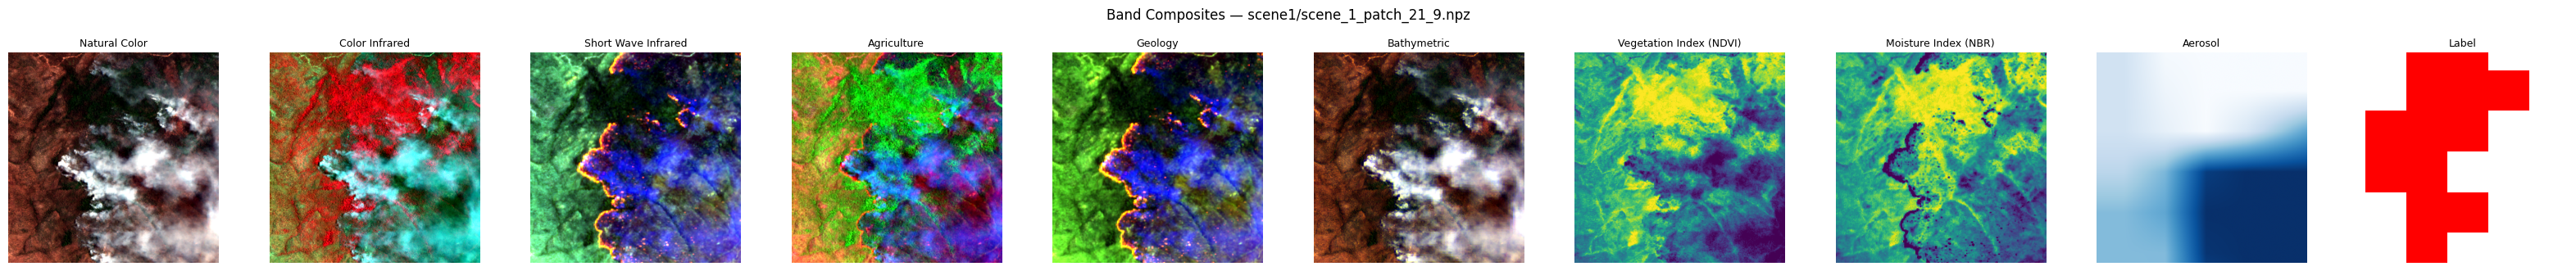

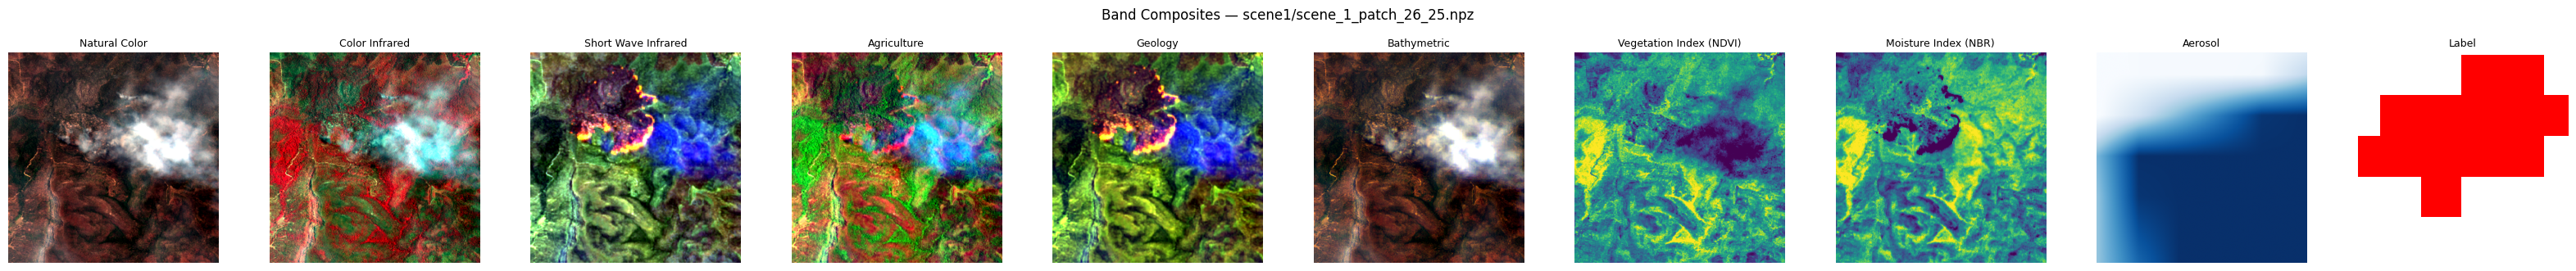

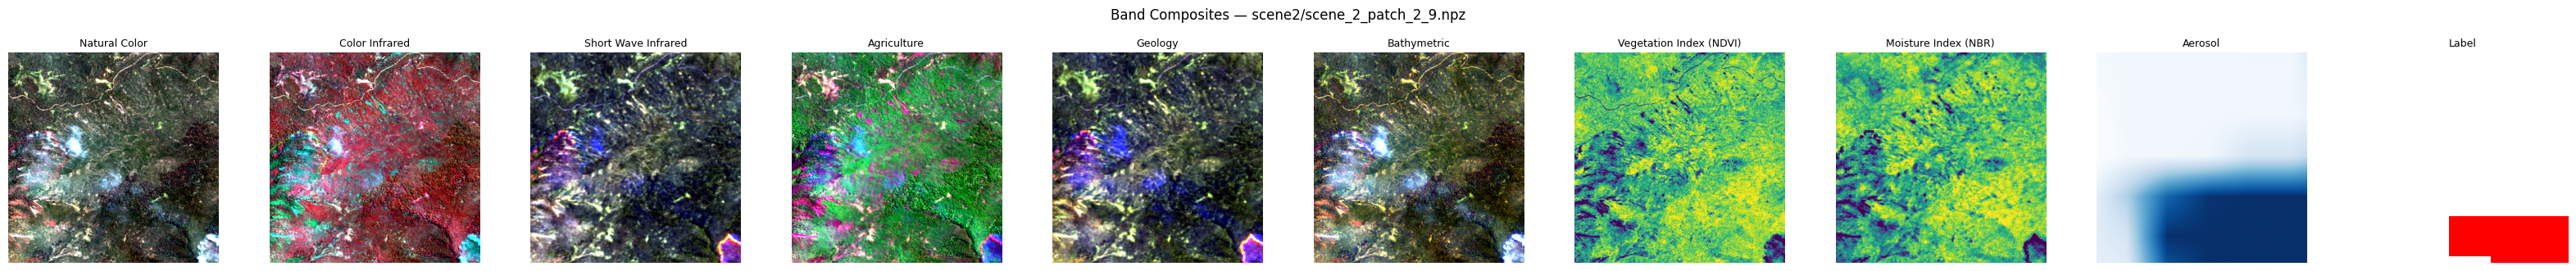

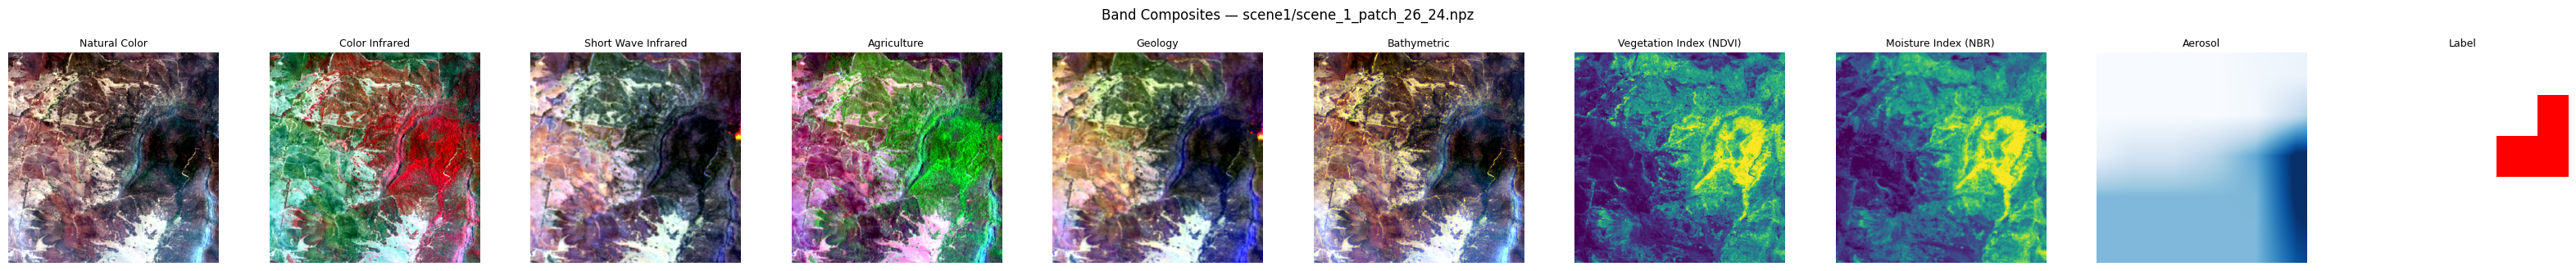

In [17]:
from matplotlib.colors import ListedColormap
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

LABEL_CMAP = ListedColormap(["white", "red"])

def show_scene_grid(scene_id, bands, label):
    modes = ["natural_color","color_infrared","short_wave_infrared",
             "agriculture","geology","bathymetric",
             "vegetation_index","moisture_index","aerosol"]
    ncols = len(modes) + 1
    fig, axes = plt.subplots(1, ncols, figsize=(3.2*ncols, 3.2), squeeze=False)
    axes = axes[0]

    for ci, mode in enumerate(modes):
        comp = visualize_composite(bands, mode)
        ax = axes[ci]
        if comp is None:
            ax.set_title(NICE_NAME[mode]+" (n/a)", fontsize=9, pad=6); ax.axis("off"); continue
        if mode == "aerosol":
            ax.imshow(comp, cmap="Blues", vmin=0, vmax=1)
        elif comp.ndim == 2:
            ax.imshow(comp, cmap="viridis", vmin=0, vmax=1)
        else:
            ax.imshow(np.clip(comp,0,1))
        ax.set_title(NICE_NAME[mode], fontsize=9, pad=6); ax.axis("off")

    # --- Label: binarize robustly and show as red/white ---
    lab = label.astype(np.float32)
    # robust binarization; handles {0,1}, {0,255}, and probs
    thr = 0.5 if lab.max() <= 1.0 else 127.5
    mask = (lab > thr).astype(np.uint8)

    ax = axes[-1]
    ax.imshow(mask, cmap=LABEL_CMAP, vmin=0, vmax=1, interpolation="nearest")
    ax.set_title("Label", fontsize=9, pad=6); ax.axis("off")

    fig.suptitle(f"Band Composites — {scene_id}", fontsize=12, y=1.02)
    out = Path("Exp")/"data_exploration"/f"{Path(scene_id).stem}_grid.png"
    out.parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout(); fig.savefig(out, dpi=220, bbox_inches="tight")
    print("Saved:", out)


for name, bands, lab in ds_iter(n=4, split_file="train.txt", mode=5):
    show_scene_grid(name, bands, lab)


### Class Balance

Samples n=120 patches using ds_iter.

For each patch, computes the fire‐pixel fraction:
fire_frac = mean(lab > 0), i.e., fraction of pixels whose label is non-zero.

Prints summary stats (N, mean, std of those fractions).

Plots a histogram of the fire fractions and saves it to Exp/data_exploration/class_balance_hist.png

N: 120 mean: 0.045693778 std: 0.14640115
Saved: Exp\data_exploration\class_balance_hist.png


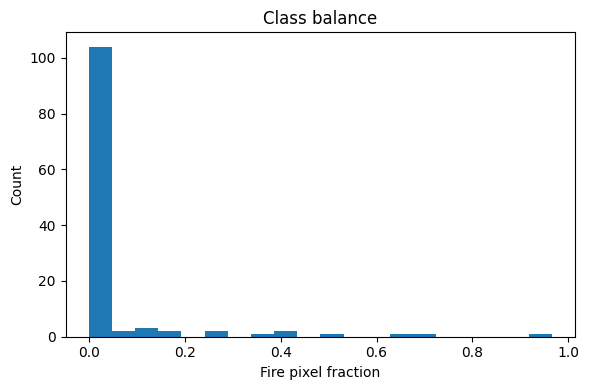

In [ ]:
# Class balance
def label_stats(n=120, split_file="train.txt"):
    vals = []
    for name, bands, lab in ds_iter(n=n, split_file=split_file):
        vals.append(float((lab>0).mean()))
    vals = np.asarray(vals, dtype=np.float32)
    print("N:", len(vals), "mean:", vals.mean(), "std:", vals.std())
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=20); plt.xlabel("Fire pixel fraction"); plt.ylabel("Count"); plt.title("Class balance")
    out = Path("Exp")/"data_exploration"/"class_balance_hist.png"
    out.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(out, dpi=160, bbox_inches="tight")
    print("Saved:", out)

label_stats(n=120, split_file="train.txt")


The big spike at ~0 means most patches contain almost no fire pixels.

mean ≈ 0.046 (≈ 4.6% of pixels are fire on average) with std ≈ 0.146.
That’s heavy class imbalance: lots of near-zero patches, a few with moderate/large fire areas that push the std up.

long tail out to 0.2–1.0, meaining there are some “fire-rich” patches.

### Single-Band Seperability

Goal: measure how well each single band by itself separates fire vs. non-fire pixels.

How it works:

For each sampled patch, it stacks the 13 channels into (C,H,W) and flattens to (N_pixels, C).

The label mask is flattened to y ∈ {0,1} (fire=1).

It optionally subsamples pixels (max 150k per patch) to keep things fast.

For each band j, it uses the raw pixel value in that band as a score and computes ROC-AUC against y.
(No model—this is just “is the value in band j higher in fire pixels than in non-fire pixels?”)

It concatenates pixels from multiple patches and plots the AUC per band.

Saved: Exp\data_exploration\per_band_auc.png


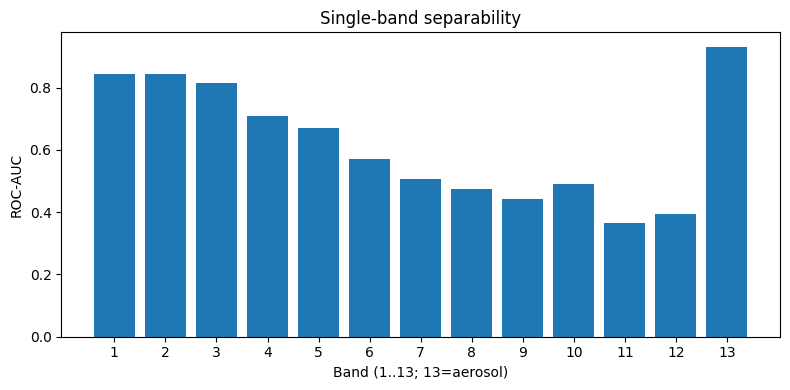

In [6]:

# Per-band AUC
import numpy as np
from sklearn.metrics import roc_auc_score

def sample_pixels(bands, label, max_pixels=150_000):
    ordered = sorted(bands.keys())
    arr = np.stack([bands[k] for k in ordered], axis=0)  # (C,H,W)
    C,H,W = arr.shape; arr = arr.reshape(C,-1).T
    y = (label.reshape(-1)>0).astype(np.uint8)
    if arr.shape[0] > max_pixels:
        idx = np.random.choice(arr.shape[0], size=max_pixels, replace=False); arr = arr[idx]; y = y[idx]
    return arr, y, ordered

def per_band_auc(n=24, split_file="train.txt"):
    Xs, Ys, names = [], [], None
    for name, bands, lab in ds_iter(n=n, split_file=split_file):
        X,y,ordered = sample_pixels(bands, lab)
        Xs.append(X); Ys.append(y); names = ordered
    X = np.concatenate(Xs, axis=0); y = np.concatenate(Ys, axis=0)
    aucs = []
    for j in range(X.shape[1]):
        try: aucs.append(roc_auc_score(y, X[:,j]))
        except Exception: aucs.append(np.nan)
    return names, np.array(aucs)

band_ids, aucs = per_band_auc()
plt.figure(figsize=(8,4))
plt.bar([str(b) for b in band_ids], np.nan_to_num(aucs))
plt.xlabel("Band (1..13; 13=aerosol)"); plt.ylabel("ROC-AUC"); plt.title("Single-band separability")
out = Path("Exp")/"data_exploration"/"per_band_auc.png"
out.parent.mkdir(parents=True, exist_ok=True)
plt.tight_layout(); plt.savefig(out, dpi=160, bbox_inches="tight")
print("Saved:", out)


Higher bar = better standalone separability of fire vs background using only that band’s intensity.



Band 13 (aerosol) is highest (~0.9 AUC): strong monotonic relation with the label in these samples.

B1–B3 (coastal/blue/green) are also high (~0.82–0.85).

Mid/longer wavelengths drop off (B6–B12 are ~0.35–0.6 here).

### Correlations

For n random patches, it:

Builds a pixel table X with one column per band (1..13; 13=aerosol) and one row per pixel.

Computes the Pearson correlation matrix corrcoef(X, rowvar=False) for that patch (correlation between bands over all pixels).

Averages those matrices across patches → C.

Plots C as a heatmap in 
−
1
,
1
−1,1:
yellow = strong positive correlation, teal = weak/near 0, purple = negative (rare here).

Saved: Exp\data_exploration\band_correlation.png


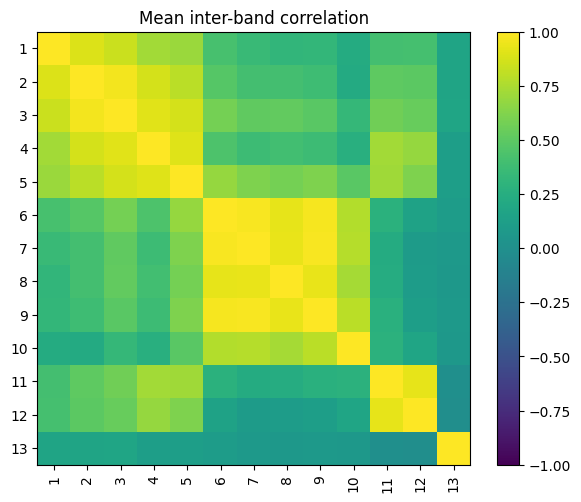

In [7]:

# Correlation
def correlation_matrix(n=12, split_file="train.txt"):
    mats, names = [], None
    for name, bands, lab in ds_iter(n=n, split_file=split_file):
        X,y,ordered = sample_pixels(bands, lab)
        mats.append(np.corrcoef(X, rowvar=False)); names = ordered
    C = np.mean(mats, axis=0)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    plt.imshow(C, vmin=-1, vmax=1); plt.colorbar()
    plt.xticks(range(len(names)), [str(b) for b in names], rotation=90)
    plt.yticks(range(len(names)), [str(b) for b in names])
    plt.title("Mean inter-band correlation")
    out = Path("Exp")/"data_exploration"/"band_correlation.png"
    out.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(out, dpi=160, bbox_inches="tight")
    print("Saved:", out)

correlation_matrix()


Visible bands (B1–B5) and red-edge/NIR (B6–B10) form two highly correlated blocks, SWIR1/2 (B11–B12) are strongly correlated to each other but less to visible/NIR, and the aerosol channel (13) is largely uncorrelated, indicating it contributes unique information likely tied to smoke/haze. This suggests potential for input reduction and targeted feature design (e.g., NBR/NDVI) without losing key signal.

##### Why this matters
Strong within-block correlation ⇒ redundancy. A model may not need every band; aggressive regularization or dimension reduction (e.g., PCA) could cut input size with little loss.

Lower correlation for SWIR1/2 and aerosol ⇒ those channels may add complementary signal (useful for burn severity/smoke).

If you plan per-band weighting or feature selection, you can:

keep one representative from highly redundant groups,

always include SWIR1/2 and aerosol,

or learn combinations (e.g., NBR = B8 vs B12, NDVI = B8 vs B4).

### Logistic Regression Baselline

The cell builds a pixel-level baseline: a logistic-regression classifier that predicts fire (1) vs non-fire (0) from the raw bands only (no CNN, no pretrained model).

For n random patches it:

Samples pixels and concatenates them into a big table X (columns = the 13 channels; 13th = aerosol) and a label vector y.

Scales each band using its 2nd–98th percentiles (robust to outliers):
Xs = (X - lo) / (hi - lo).

Fits LogisticRegression(class_weight="balanced") on these pixels (train-only; no hold-out split).

Prints AUC, Average Precision (AP), and Accuracy computed on the same pixels it trained on.

Plots the learned weights per band (positive weight ⇒ higher values push the model toward “fire”; negative weight ⇒ higher values push toward “non-fire”).

AUC=0.975  AP=0.331  Acc=0.908
Saved: Exp\data_exploration\baseline_logreg_weights.png


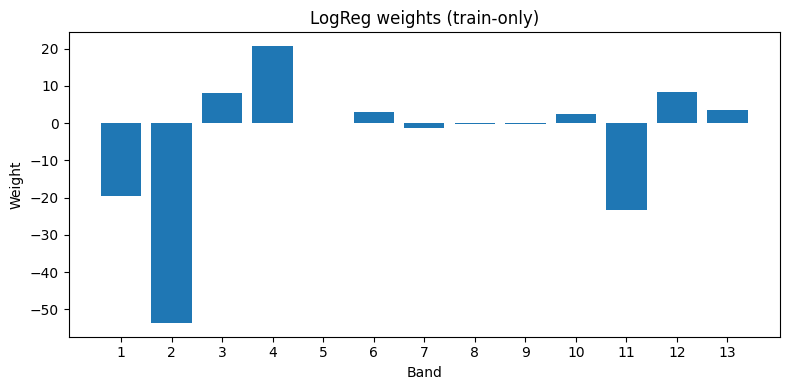

In [8]:

# Logistic regression baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score

def baseline_logreg(n=25, split_file="train.txt"):
    Xs,Ys,names = [],[],None
    for name, bands, lab in ds_iter(n=n, split_file=split_file):
        X,y,ordered = sample_pixels(bands, lab)
        Xs.append(X); Ys.append(y); names = ordered
    X = np.concatenate(Xs, axis=0); y = np.concatenate(Ys, axis=0)
    lo = np.percentile(X, 2, axis=0); hi = np.percentile(X, 98, axis=0)
    Xs = (X - lo) / (hi - lo + 1e-6)
    clf = LogisticRegression(max_iter=200, n_jobs=1, C=0.5, class_weight="balanced")
    clf.fit(Xs,y); prob = clf.predict_proba(Xs)[:,1]
    auc = roc_auc_score(y, prob); ap = average_precision_score(y, prob); acc = accuracy_score(y, (prob>0.5).astype(np.uint8))
    print(f"AUC={auc:.3f}  AP={ap:.3f}  Acc={acc:.3f}")
    w = clf.coef_.reshape(-1)
    plt.figure(figsize=(8,4)); plt.bar([str(b) for b in names], w)
    plt.xlabel("Band"); plt.ylabel("Weight"); plt.title("LogReg weights (train-only)")
    out = Path("Exp")/"data_exploration"/"baseline_logreg_weights.png"
    out.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(out, dpi=160, bbox_inches="tight")
    print("Saved:", out)

baseline_logreg()


AUC ≈ 0.975: The classifier separates positives and negatives very well on the training data. This is optimistic because there’s no validation split.

AP ≈ 0.331: Precision–recall is modest, which is typical under strong class imbalance (most pixels are background).

Acc ≈ 0.908: High accuracy largely reflects the large number of negatives; accuracy alone would overstate performance here.

##### What this suggests

Even a tiny linear model can separate classes fairly well on sampled pixels, meaning the dataset has usable signal in the raw bands.

Because training and evaluation happen on the same pixels, results are optimistic; a held-out patch-level test is needed for reliable numbers.

Imbalance explains the gap: AUC high, AP modest, accuracy high.

Correlation + weights together imply redundancy among visible & red-edge/NIR groups; SWIR2 and aerosol may add complementary signal.

### Conclusion & rationale

**What the exploration shows**

* **Class balance:** Most patches contain **very little fire** (mean ~4-5% fire pixels; long tail of fire-rich patches). This confirms a **strong class imbalance** that will bias naïve models toward background.
* **Band composites & indices:** RGB/CIR/SWIR views plus **NDVI** and **NBR** help visually verify registration, clouds/smoke, and burn patterns. They make it clear that **SWIR & NIR emphasize burn/moisture**, while RGB offers intuitive QA.
* **Single-band separability (ROC-AUC):** The **aerosol channel** and **visible bands (B1- B3)** are highly separable in the sampled data; raw **SWIR** bands are weaker alone, supporting the use of **indices (e.g., NBR = B8 vs B12)** rather than single SWIR values.
* **Inter-band correlation:** Visible (B1- B5) and red-edge/NIR (B6- B10) form **two strongly correlated blocks**; **SWIR1/2 (B11/B12)** are tightly correlated to each other but less to the others; **aerosol** is largely **independent**. This indicates **redundancy** in some groups and **complementary signal** from SWIR and aerosol.
* **Logistic-regression baseline:** A simple linear model trained on pixels achieves **high AUC** (optimistic, train-only) and moderate AP under imbalance, implying the dataset contains **usable signal** even without complex models. Weight patterns align with the correlation picture (redundant groups; distinctive SWIR/aerosol contribution).

**Why these analyses/visualizations**

* **Composites & indices**: fast, human-interpretable QA to ensure inputs and labels look plausible, and to see which spectral regions highlight fire/burn/smoke.
* **Class balance histogram**: quantifies the **imbalance problem** to motivate sampling, loss weighting (e.g., focal/Dice), and evaluation beyond accuracy.
* **Per-band AUC**: a **model-free measure** of which wavelengths correlate with fire, guiding band selection and index engineering (NDVI/NBR).
* **Correlation heatmap**: reveals **redundancy** and **complementarity** across bands, useful for feature pruning, regularization, or dimensionality reduction.
* **Linear baseline**: a quick sanity check that **signal exists** and to get a first sense of **feature importance** before investing in heavier models.
